<center><img src =  ></center>

# **<center><font color='black'>K.J Somaiya College of Engineering</font></center>**

## <center><font color='red'>Engineering Final Year Project</font></center>

## <center>**<font color='purple'>InsureBuddy - An Insurance Recommender System</font></center>**


### **Author:**
### **Sujay Torvi**
### Co-Authors:
### 1. Krupen Shah
### 2. Harsh Somaiya
### 3. Tirth Desai

### Copyright© 2020 Under MIT License 

## **<font color='purple'>`Problem Statement: To process, analyse and mine the data for useful insights in insurance product recommendation and model them using various algorithms, and deploying them into an application which would provide the user with useful insurance product recommendations`</font>**

## **IV. Machine Learning - II** 
### Bayesian Neural Network

## **Source of Dataset:**
### **Zimnnat Insurance Recommendation Dataset**

URL: https://zindi.africa/competitions/zimnat-insurance-recommendation-challenge

<br>

**<font color='red'>Important:</font>**

**<font color='purple'>Since no metadata is given for this dataset we are free to remove and impute our own attributes</font>**

### Load the dataset 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
from google.colab import files
u = files.upload()

Saving TF1.JPG to TF1.JPG


In [4]:
train = pd.read_excel('Training_Data_rebalanced.xlsx')

In [5]:
test = pd.read_excel('Testing_Data.xlsx')

In [6]:
train = train[['sex', 'marital_status', 'age_group', 'occupation_category_code','Annual_Income','Policy 1','Policy 2','Policy 3','Policy 4','Policy 5']]

In [7]:
test = test[['sex', 'marital_status', 'age_group', 'occupation_category_code','Annual_Income','Policy 1','Policy 2','Policy 3','Policy 4','Policy 5']]

In [8]:
test.head()

,sex,marital_status,age_group,occupation_category_code,Annual_Income,Policy 1,Policy 2,Policy 3,Policy 4,Policy 5
0,1,0,0,1,1,1,1,0,0,0
1,1,0,0,2,1,1,1,0,0,0
2,0,0,1,2,3,1,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0


In [9]:
train.head()

,sex,marital_status,age_group,occupation_category_code,Annual_Income,Policy 1,Policy 2,Policy 3,Policy 4,Policy 5
0,0,0,0,0,1,1,1,0,0,0
1,0,0,0,0,1,1,1,0,0,0
2,1,1,0,4,1,1,0,0,0,0
3,1,0,0,2,1,1,1,0,0,0
4,1,0,0,0,1,0,0,0,1,1


In [10]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
le = preprocessing.LabelEncoder()
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [11]:
train = pd.DataFrame(train.apply(preprocessing.LabelEncoder().fit_transform))

In [12]:
X_train = train[train.columns[:5]]
X_test =  test[test.columns[:5]]
y_train = train[train.columns[5:]]
y_test =  test[test.columns[5:]]

### We have a Train and Test Dataset, However we do not have a Validation Dataset

### So, we Split the Test Dataset into Validation and Test Set

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.2)

### Import Tensorflow Probability for Bayesian Neural Network & Keras Library

In [14]:
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

### Checking if system has a gpu, and allow tensorflow probability and keras to use gpu

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12422981058866178328
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15581304216058339224
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


### The KL Divergence Function defined below is the main backbone of the Bayesian Neural Network that we construct

### It is resposible to measure the difference between two probability distributions. 

### This acts like a cost function which allows a network to assess it's performance in prediction and learn to improve it's performance

In [16]:
kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(len(X_train), dtype=tf.float64))

In [17]:
n_epochs = 25
n_samples = X_train.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)

### Define Prior Probability which is needed for all bayesian networks

In [18]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(5, dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

### Construct Bayesian Neural Network Model

In [20]:
with tf.device("/device:GPU:0"):
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(5,),name="inp"),
    tfp.layers.DenseFlipout(24, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_1"),
    tfp.layers.DenseFlipout(12, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_2"),
    tfp.layers.DenseFlipout(6, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_3"),
    tfp.layers.DenseFlipout(5, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.sigmoid, name="out_tfp_pred"),
])

### The above bayesian neural network has an input and 4 DenseFlipout Layers. 

### A Dense flipout layer is a standard neural network hidden layer with a flipout estimator which enables bayesian inference operations such as:

### 1. Calculate Prior and Posterior Probability - Likelihood of the output of the next layer

### 2. Approximate the distribution of the output of each hidden layer 

In [21]:
with tf.device("/device:GPU:0"):
  model.compile(optimizer="adam", loss='binary_crossentropy', metrics = ['accuracy','AUC'])

In [22]:
pwd_ = '/content'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=pwd_, histogram_freq=1)

In [24]:
data = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [25]:
data_test = data.skip(n_samples).batch(1).repeat(n_epochs)

In [26]:
data_train = data.take(n_samples).batch(batch_size).repeat(n_epochs)

In [27]:
val = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val = val.shuffle(len(X_val), reshuffle_each_iteration=True)

In [28]:
data_val = val.take(len(X_val)).batch(batch_size).repeat(n_epochs)

### Run the model

In [29]:
with tf.device("/device:GPU:0"):
  model.fit(data_train, epochs=n_epochs, validation_data=data_val, verbose=True,callbacks=[tensorboard_callback])

Epoch 1/25
275/275 [==============================] - 10s 22ms/step - loss: 0.6602 - accuracy: 0.2450 - auc: 0.6534 - val_loss: 0.5379 - val_accuracy: 0.8029 - val_auc: 0.8510
Epoch 2/25
275/275 [==============================] - 5s 19ms/step - loss: 0.3388 - accuracy: 0.6942 - auc: 0.9323 - val_loss: 0.5263 - val_accuracy: 0.8696 - val_auc: 0.8393
Epoch 3/25
275/275 [==============================] - 5s 19ms/step - loss: 0.2775 - accuracy: 0.9136 - auc: 0.9497 - val_loss: 0.5221 - val_accuracy: 0.8877 - val_auc: 0.8394
Epoch 4/25
275/275 [==============================] - 5s 19ms/step - loss: 0.2727 - accuracy: 0.9433 - auc: 0.9510 - val_loss: 0.5133 - val_accuracy: 0.8933 - val_auc: 0.8386
Epoch 5/25
275/275 [==============================] - 5s 19ms/step - loss: 0.2706 - accuracy: 0.9470 - auc: 0.9521 - val_loss: 0.5110 - val_accuracy: 0.8949 - val_auc: 0.8402
Epoch 6/25
275/275 [==============================] - 5s 19ms/step - loss: 0.2694 - accuracy: 0.9467 - auc: 0.9528 - val_los

### Visualizing Model Statistics using Tensorboard

In [56]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content

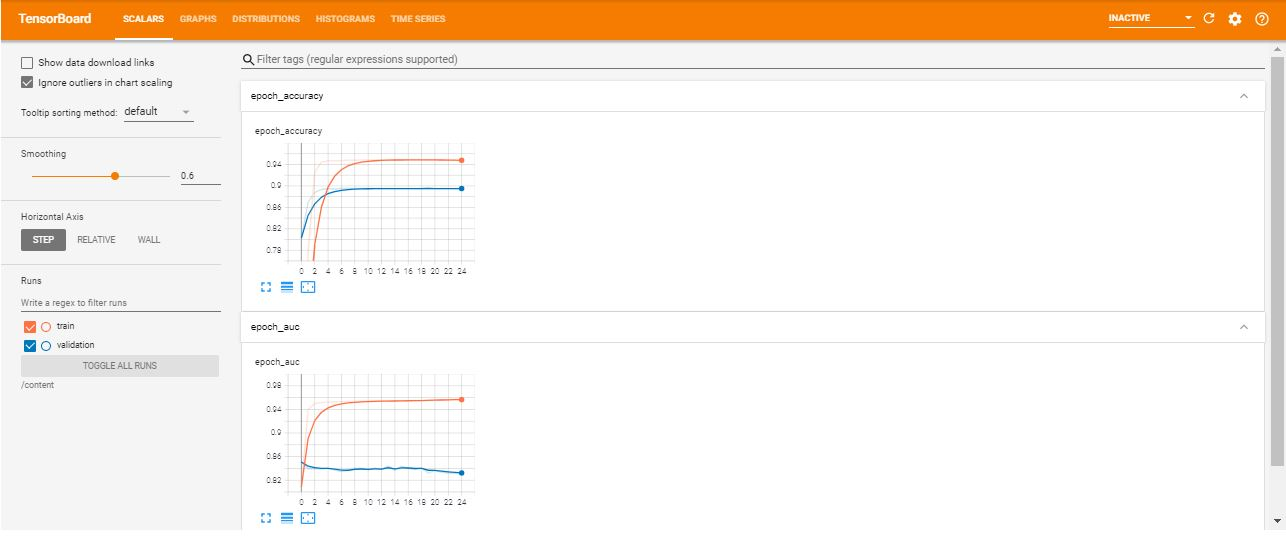

In [69]:
from IPython.display import display, Image
display(Image(filename='/content/TF1.JPG'))

### Check model accuracy on Test Set 

### Since this is a bayesian neural network, it will predict 10 outputs for each sample. The mean of the 10 outputs are taken and then rounded off. The resulting value is the final output and determines if the policy is to be recommended to the user or not

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
test_set = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_set = test_set.shuffle(len(X_test), reshuffle_each_iteration=True)
testing_data = test_set.take(len(X_test)).batch(1).repeat(n_epochs)

In [32]:
samples = len(X_test)
iterations = 10

In [33]:
test_iterator = tf.compat.v1.data.make_one_shot_iterator(testing_data)

In [34]:
inputs = list(train.columns[:5])
outputs = list(train.columns[5:])

In [35]:
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(shape=(samples, len(outputs), iterations))

In [36]:
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    if(i%50 == 0):
      print('Predicting Sample {} ::: Please wait....'.format(i))
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)

Predicting Sample 0 ::: Please wait....
Predicting Sample 50 ::: Please wait....
Predicting Sample 100 ::: Please wait....
Predicting Sample 150 ::: Please wait....
Predicting Sample 200 ::: Please wait....
Predicting Sample 250 ::: Please wait....
Predicting Sample 300 ::: Please wait....
Predicting Sample 350 ::: Please wait....
Predicting Sample 400 ::: Please wait....
Predicting Sample 450 ::: Please wait....
Predicting Sample 500 ::: Please wait....
Predicting Sample 550 ::: Please wait....
Predicting Sample 600 ::: Please wait....
Predicting Sample 650 ::: Please wait....
Predicting Sample 700 ::: Please wait....
Predicting Sample 750 ::: Please wait....
Predicting Sample 800 ::: Please wait....
Predicting Sample 850 ::: Please wait....
Predicting Sample 900 ::: Please wait....
Predicting Sample 950 ::: Please wait....
Predicting Sample 1000 ::: Please wait....
Predicting Sample 1050 ::: Please wait....
Predicting Sample 1100 ::: Please wait....
Predicting Sample 1150 ::: Please 

In [37]:
Y_pred_m = np.mean(Y_pred, axis=-1)

In [38]:
y_pred = np.round(Y_pred_m)

In [ ]:
print('Test accuracy is {}%'.format(accuracy_score(Y_true, y_pred)*100))

Test accuracy is 80.33295063145809%


### Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

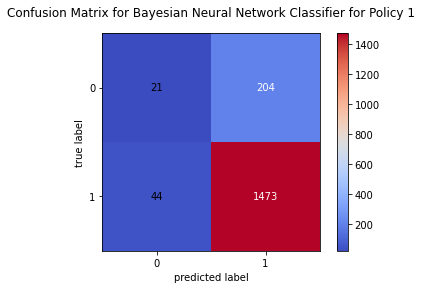

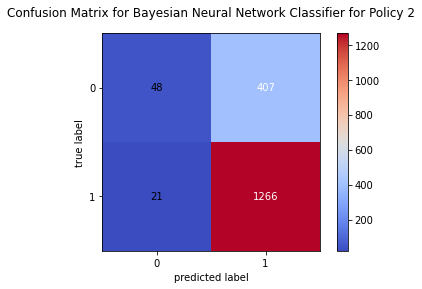

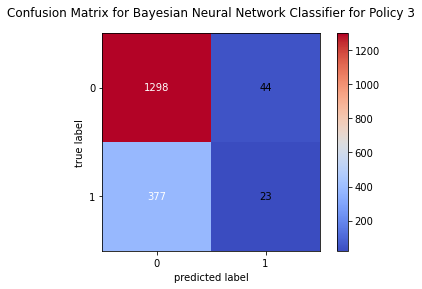

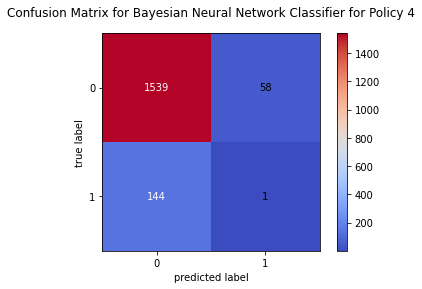

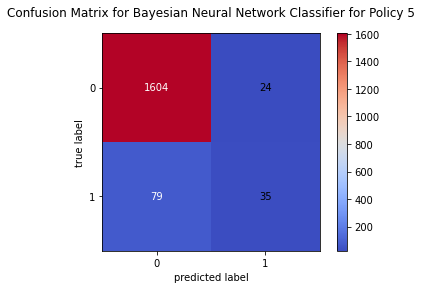

In [ ]:
cm1 = multilabel_confusion_matrix(Y_true, y_pred)
for i in range(0,5):
  fig, ax = plot_confusion_matrix(conf_mat=cm1[i],cmap='coolwarm',colorbar=True)
  plt.title('Confusion Matrix for Bayesian Neural Network Classifier for Policy {}'.format(i+1))
  plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['Policy 1', 'Policy 2', 'Policy 3', 'Policy 4', 'Policy 5']

In [ ]:
print('Report for Bayesian Neural Network Classifier')
print(classification_report(Y_true,y_pred, target_names=target_names))

Report for Bayesian Neural Network Classifier
              precision    recall  f1-score   support

    Policy 1       0.88      0.97      0.92      1517
    Policy 2       0.76      0.98      0.86      1287
    Policy 3       0.34      0.06      0.10       400
    Policy 4       0.02      0.01      0.01       145
    Policy 5       0.59      0.31      0.40       114

   micro avg       0.79      0.81      0.80      3463
   macro avg       0.52      0.47      0.46      3463
weighted avg       0.73      0.81      0.75      3463
 samples avg       0.80      0.77      0.78      3463



### **<center>Performance of Bayesian Neural Network**

|Training Accuracy| Validation Accuracy | Testing Accuracy 
| --- | --- | --- |
| 94% | 89% | 80% |


### Save the Model

In [48]:
model.save("bayesian_nn")

INFO:tensorflow:Assets written to: bayesian_nn/assets


In [ ]:
import shutil

In [54]:
shutil.make_archive('bayesian_nn', 'zip', 'bayesian_nn')

'/content/bayesian_nn.zip'

In [ ]:
!pip install h5py

### Saving Model in HDF5 Format

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("bayesian_nn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("bayesian_nn.h5")
print("Saved model to disk")

Saved model to disk


### References:

### 1. https://towardsdatascience.com/bayesian-neural-networks-with-tensorflow-probability-fbce27d6ef6

### 2. https://www.tensorflow.org/tensorboard/get_started

### 3. https://analyticsindiamag.com/decoding-kl-divergence-and-its-significance-in-machine-learning/

### 4. https://www.tensorflow.org/probability/api_docs/python/tfp/